### main_pretrain

In [61]:
from main_pretrains.main_pretrain import main_pretrain, set_seed
from models.gru import GRU_SOH
from data_provider import data_provider
import torch
import torch.optim as optim
import random
import numpy as np

source_set_train, source_loader_train = data_provider(name = 'GOTION', shuffle_flag=True, batch_size=10, flag = 'train')
source_set_test, source_loader_test = data_provider(name = 'GOTION', shuffle_flag=False, batch_size=10, flag = 'test')

# model parameters
input_dim = 1
embed_dim = 128
# num_heads = 4
num_layers = 2

# training parameters
mask_ratrio = 0.3
num_epochs = 10
LR = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
f_g = GRU_SOH(input_dim, embed_dim,  num_layers, PPA= True).to(device)
optimizer = optim.AdamW(f_g.parameters(), lr=LR)
set_seed(0)
main_pretrain(train_loader= source_loader_train, test_loader= source_loader_test, model=f_g, optimizer=optimizer, device=device,mask_ratio=mask_ratrio, num_epochs=num_epochs)
torch.save(f_g.state_dict(), 'saved_models/gru/f_g.pt')

GOTION train 2840
GOTION test 1419
cuda
Epoch [1/10], Reconstruction (train) Loss: 0.0029565508074240274, Reconstruction (test) Loss: 0.0004905521868429684
Epoch [2/10], Reconstruction (train) Loss: 0.00033215482154177355, Reconstruction (test) Loss: 0.00020939189090941128
Epoch [3/10], Reconstruction (train) Loss: 0.00019076093096219652, Reconstruction (test) Loss: 0.00014319523232726668
Epoch [4/10], Reconstruction (train) Loss: 0.00012589028641049878, Reconstruction (test) Loss: 0.00012956165680317472
Epoch [5/10], Reconstruction (train) Loss: 0.00010054781070183208, Reconstruction (test) Loss: 0.00011450324284812948
Epoch [6/10], Reconstruction (train) Loss: 6.898009325570303e-05, Reconstruction (test) Loss: 8.176534469333694e-05
Epoch [7/10], Reconstruction (train) Loss: 5.445050687163709e-05, Reconstruction (test) Loss: 8.58890208279186e-05
Epoch [8/10], Reconstruction (train) Loss: 5.2329290136979796e-05, Reconstruction (test) Loss: 6.610739311186145e-05
Epoch [9/10], Reconstruc

### main_prob

In [115]:
from main_pretrains.main_prob import main_prob
from data_provider import data_provider
from models.gru import GRU_SOH
import torch
import torch.optim as optim
import torch.nn as nn
from main_pretrains.main_pretrain import set_seed

source_set_train, source_loader_train = data_provider(name = 'GOTION', shuffle_flag=True, batch_size=10, flag = 'train')
target_set_train, target_loader_train = data_provider(name = 'GOTION', shuffle_flag=False, batch_size=10, flag = 'train')
target_set_test, target_loader_test = data_provider(name = 'GOTION', shuffle_flag=False, batch_size=10, flag = 'test')

LR = 1e-3
EPOCH = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

f_g = GRU_SOH(input_dim=1, embed_dim=128, num_layers=2, PPA= True).to(device)
f_g.load_state_dict(torch.load("saved_models/gru/f_g.pt"))
regressor = nn.Linear(f_g.input_linear.out_features, 1).to(device)
optimizer = optim.AdamW(regressor.parameters(), lr=LR)

set_seed(0)
main_prob(source_loader_train, target_loader_train, combined_training=True, model=f_g, regressor=regressor, optimizer=optimizer, device=device, num_epochs=EPOCH)
torch.save(regressor.state_dict(), 'saved_models/gru/regressor.pt')

GOTION train 2840
GOTION train 2840
GOTION test 1419
cuda
Epoch [1/5], Source Loader Loss: 0.013830905829885344
Target Loader - MAE: 0.00894983485341072, RMSE: 0.009785362519323826
Epoch [2/5], Source Loader Loss: 8.084916834390319e-05
Target Loader - MAE: 0.008250396698713303, RMSE: 0.009125501848757267
Epoch [3/5], Source Loader Loss: 7.751265123991121e-05
Target Loader - MAE: 0.009136776439845562, RMSE: 0.009993036277592182
Epoch [4/5], Source Loader Loss: 7.337936638347382e-05
Target Loader - MAE: 0.00902972649782896, RMSE: 0.009916532784700394
Epoch [5/5], Source Loader Loss: 6.882476202623416e-05
Target Loader - MAE: 0.0074567547999322414, RMSE: 0.008422832004725933


(1419,)
(1419,)


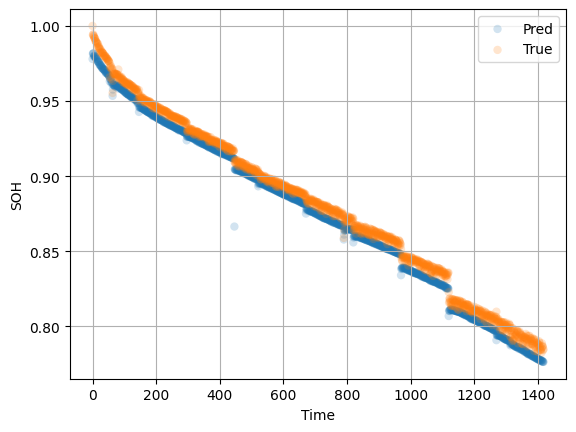

In [116]:
from drawings import drawDegradation
drawDegradation(target_loader_test=target_loader_test, model=f_g, regressor=regressor, device = device)

### tta

In [117]:
f_g = GRU_SOH(input_dim=1, embed_dim=128,  num_layers=2,  PPA= True).to(device)
f_g.load_state_dict(torch.load("saved_models/gru/f_g.pt"))
regressor = nn.Linear(f_g.input_linear.out_features, 1).to(device)
regressor.load_state_dict(torch.load("saved_models/gru/regressor.pt"))

# Print trainable and frozen parameters
print("Trainable parameters:")
trainable_params_count = 0
for name, param in f_g.named_parameters():
    if name =='soft_prompt':
        print('PPA params:', param.numel())
    if param.requires_grad:
        print(name)
        trainable_params_count += param.numel()

print("\nFrozen parameters:")
frozen_params_count = 0
for name, param in f_g.named_parameters():
    if not param.requires_grad:
        print(name)
        frozen_params_count += param.numel()

print(f"\nNumber of trainable parameters: {trainable_params_count}")
print(f"Total number of parameters: {trainable_params_count + frozen_params_count}")
print(f"Number of frozen parameters: {frozen_params_count}")

Trainable parameters:
PPA params: 1280
soft_prompt
input_linear.weight
input_linear.bias
gru.weight_ih_l0
gru.weight_hh_l0
gru.bias_ih_l0
gru.bias_hh_l0
gru.weight_ih_l1
gru.weight_hh_l1
gru.bias_ih_l1
gru.bias_hh_l1
output_linear.weight
output_linear.bias

Frozen parameters:

Number of trainable parameters: 199809
Total number of parameters: 199809
Number of frozen parameters: 0


In [118]:
from main_pretrains.main_tta import main_tta
from evaluator import evaluate

optimizer = optim.SGD(f_g.parameters(), lr=1e-1)
# optimizer = optim.SGD([f_g.soft_prompt], lr=50e-1)

set_seed(4)
mae, rmse = evaluate(model = f_g, model_name='gru', regressor=regressor, target_loader=target_loader_test, device=device)
print(f"(Before TTA) MAE: {mae}, RMSE: {rmse}")
f_g=f_g.train()
main_tta(target_loader=target_loader_test, model=f_g, regressor=regressor, optimizer=optimizer, device=device, mask_ratio=0.8, num_epochs=100)

mae, rmse = evaluate(model = f_g, model_name='gru', regressor=regressor, target_loader=target_loader_test, device=device)
print(f"(After TTA) MAE: {mae}, RMSE: {rmse}")

(Before TTA) MAE: 0.006773566361516714, RMSE: 0.007148320320993662
Epoch [1/100], TTA Reconstruction Loss: 0.01197932019065672
Target Loader - MAE: 0.013430321589112282, RMSE: 0.013616429641842842
Epoch [2/100], TTA Reconstruction Loss: 0.007185815063692157
Target Loader - MAE: 0.01672961749136448, RMSE: 0.016877207905054092
Epoch [3/100], TTA Reconstruction Loss: 0.005797831721203795
Target Loader - MAE: 0.014620745554566383, RMSE: 0.014788352884352207
Epoch [4/100], TTA Reconstruction Loss: 0.004968312495998041
Target Loader - MAE: 0.013224772177636623, RMSE: 0.013410788029432297
Epoch [5/100], TTA Reconstruction Loss: 0.005519400829527999
Target Loader - MAE: 0.010746728628873825, RMSE: 0.010981498286128044
Epoch [6/100], TTA Reconstruction Loss: 0.004638978449421161
Target Loader - MAE: 0.009726250544190407, RMSE: 0.00999100599437952
Epoch [7/100], TTA Reconstruction Loss: 0.004555515521927409
Target Loader - MAE: 0.008408905006945133, RMSE: 0.008723650127649307
Epoch [8/100], TTA 

In [114]:
mae, rmse = evaluate(model = f_g, model_name='lstm', regressor=regressor, target_loader=target_loader_test, device=device)
print(f"(Before TTA) MAE: {mae}, RMSE: {rmse}")
f_g=f_g.train()
main_tta(target_loader=target_loader_test, model=f_g, regressor=regressor, optimizer=optimizer, device=device, mask_ratio=0.95, num_epochs=200)

mae, rmse = evaluate(model = f_g, model_name='lstm', regressor=regressor, target_loader=target_loader_test, device=device)
print(f"(After TTA) MAE: {mae}, RMSE: {rmse}")

(Before TTA) MAE: 0.01897229067981243, RMSE: 0.029293928295373917
Epoch [1/200], TTA Reconstruction Loss: 0.02640812274498435
Target Loader - MAE: 0.019990842789411545, RMSE: 0.030358297750353813
Epoch [2/200], TTA Reconstruction Loss: 0.024940618715034082
Target Loader - MAE: 0.01976063661277294, RMSE: 0.030120985582470894
Epoch [3/200], TTA Reconstruction Loss: 0.02452533309562848
Target Loader - MAE: 0.019344530999660492, RMSE: 0.029683778062462807
Epoch [4/200], TTA Reconstruction Loss: 0.021232679314338244
Target Loader - MAE: 0.01913919299840927, RMSE: 0.02946452423930168
Epoch [5/200], TTA Reconstruction Loss: 0.020142447887561643
Target Loader - MAE: 0.018882161006331444, RMSE: 0.029179329052567482
Epoch [6/200], TTA Reconstruction Loss: 0.021600185288116337
Target Loader - MAE: 0.01856059953570366, RMSE: 0.028806230053305626
Epoch [7/200], TTA Reconstruction Loss: 0.02094218847520936
Target Loader - MAE: 0.018508445471525192, RMSE: 0.02874426171183586
Epoch [8/200], TTA Recons

(637,)
(637,)


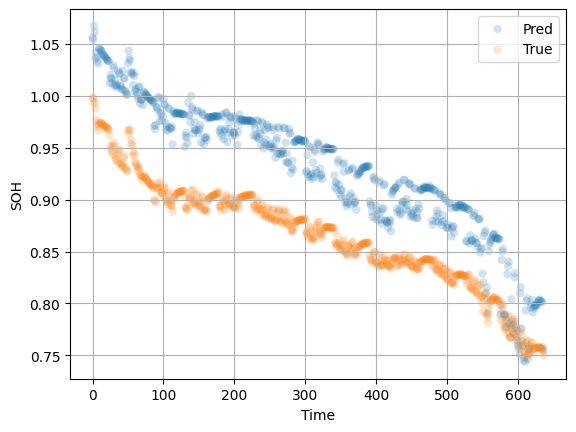

In [30]:
from drawings import drawDegradation
drawDegradation(target_loader_test=target_loader_test, model=f_g, regressor=regressor, device = device)

## TTA with PPA